In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import copy
import pickle

# Importing data

In [2]:
def data_import(data_path):
    class_labels = os.listdir(data_path) # reads directory names as class-labels
    data=[]
    labels=[]
    for class_ in class_labels:
        if class_ == '.DS_Store':
            continue
        class_path = data_path+'/'+class_
        imgs = os.listdir(class_path) # reads images names to read
        for img in imgs:
            if img == '.DS_Store':
                continue
            data.append(cv2.imread(class_path+'/'+img, cv2.IMREAD_GRAYSCALE))
            labels.append(int(class_))

    return np.array(data), np.array(labels)

In [3]:
test_path='./Group_10/test'
train_path='./Group_10/train'
val_path='./Group_10/val'
# test_data, test_labels = data_import(test_path)
# train_data, train_labels = data_import(train_path)
# val_data, val_labels = data_import(val_path)

# with open('test_data', mode='wb') as f:
#     pickle.dump(test_data, f)
# with open('train_data', mode='wb') as f:
#     pickle.dump(train_data, f)
# with open('val_data', mode='wb') as f:
#     pickle.dump(val_data, f)

# with open('test_labels', mode='wb') as f:
#     pickle.dump(test_labels, f)
# with open('train_labels', mode='wb') as f:
#     pickle.dump(train_labels, f)
# with open('val_labels', mode='wb') as f:
#     pickle.dump(val_labels, f)

with open('test_data', mode='rb') as f:
    test_data = pickle.load(f)
with open('train_data', mode='rb') as f:
    train_data = pickle.load(f)
with open('val_data', mode='rb') as f:
    val_data = pickle.load(f)

with open('test_labels', mode='rb') as f:
    test_labels = pickle.load(f)
with open('train_labels', mode='rb') as f:
    train_labels = pickle.load(f)
with open('val_labels', mode='rb') as f:
    val_labels = pickle.load(f)

print('Summary of data')
print(f'No. of train images: {len(train_data)}')
print(f'No. of test images: {len(test_data)}')
print(f'No. of val images: {len(val_data)}')

Summary of data
No. of train images: 11385
No. of test images: 3795
No. of val images: 3795


## RMSProp

### Model

In [4]:
initializer = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=6)
# Three layer FCNN
model_3 = keras.Sequential([
    Flatten(input_shape=(28,28), name='Input_layer'), # image data as input
    Dense(128, activation='sigmoid', name='Hidden_layer_1'),
    Dense(100, activation='sigmoid', name='Hidden_layer_2'),
    Dense(128, activation='sigmoid', name='Hidden_layer_3'),
    Dense(10, activation='softmax', name='Output')
], name='FCNN_3layer')
model_3.summary()

Model: "FCNN_3layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 Hidden_layer_2 (Dense)      (None, 100)               12900     
                                                                 
 Hidden_layer_3 (Dense)      (None, 128)               12928     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 127,598
Trainable params: 127,598
Non-trainable params: 0
_________________________________________________________________


In [5]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=3, verbose=1)
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001,
        rho=0.99, epsilon=1e-8, centered=False,
        name="RMSProp")
model_3.compile(optimizer=rmsprop,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [6]:
history = model_3.fit(x=train_data, y=train_labels, batch_size=1, epochs=100_000,
                    callbacks=[earlystopping],
                    verbose=1, shuffle=True,
                    validation_split=0.0, validation_data=(val_data, val_labels), validation_batch_size=None)

Epoch 1/100000


2023-03-16 13:54:01.666925: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11385/11385 [==============================] - 8s 659us/step - loss: 1.3047 - accuracy: 0.3837 - val_loss: 1.0494 - val_accuracy: 0.5115
Epoch 2/100000
11385/11385 [==============================] - 8s 678us/step - loss: 1.0589 - accuracy: 0.5129 - val_loss: 1.1170 - val_accuracy: 0.4867
Epoch 3/100000
11385/11385 [==============================] - 7s 641us/step - loss: 1.0646 - accuracy: 0.5096 - val_loss: 0.9319 - val_accuracy: 0.5515
Epoch 4/100000
11385/11385 [==============================] - 7s 649us/step - loss: 0.9151 - accuracy: 0.5828 - val_loss: 0.9264 - val_accuracy: 0.5581
Epoch 5/100000
11385/11385 [==============================] - 8s 665us/step - loss: 0.8642 - accuracy: 0.6047 - val_loss: 0.9227 - val_accuracy: 0.5481
Epoch 6/100000
11385/11385 [==============================] - 7s 655us/step - loss: 0.8740 - accuracy: 0.5787 - val_loss: 0.8943 - val_accuracy: 0.6063
Epoch 7/100000
11385/11385 [==============================] - 8s 683us/step - loss: 0.8331 - accuracy: 

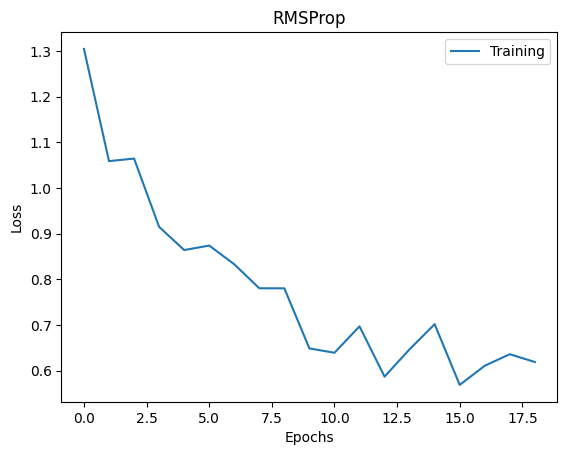

In [7]:
plt.figure()
plt.title("RMSProp")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

### Test

In [8]:
model_3.evaluate(test_data, test_labels)

119/119 [==============================] - 0s 450us/step - loss: 0.6120 - accuracy: 0.8340


[0.6119946241378784, 0.8339921236038208]

In [10]:
pred_labels = model_3.predict(test_data, verbose=0)
pred_labels = np.argmax(pred_labels, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels, pred_labels, num_classes=10)
print('(RMSProp)Confusion matrix on test data:\n')
print(confusion_matrix.numpy())

(RMSProp)Confusion matrix on test data:

[[751   0   3   0   0   0   3   2   0   0]
 [  1 713  17   0   0   0  27   1   0   0]
 [175  78 380   0   0   0 117   9   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 94  11   6   0   0   0 648   0   0   0]
 [ 15  17  46   0   0   0   8 673   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
